Tech: TF-IDF Vectorization
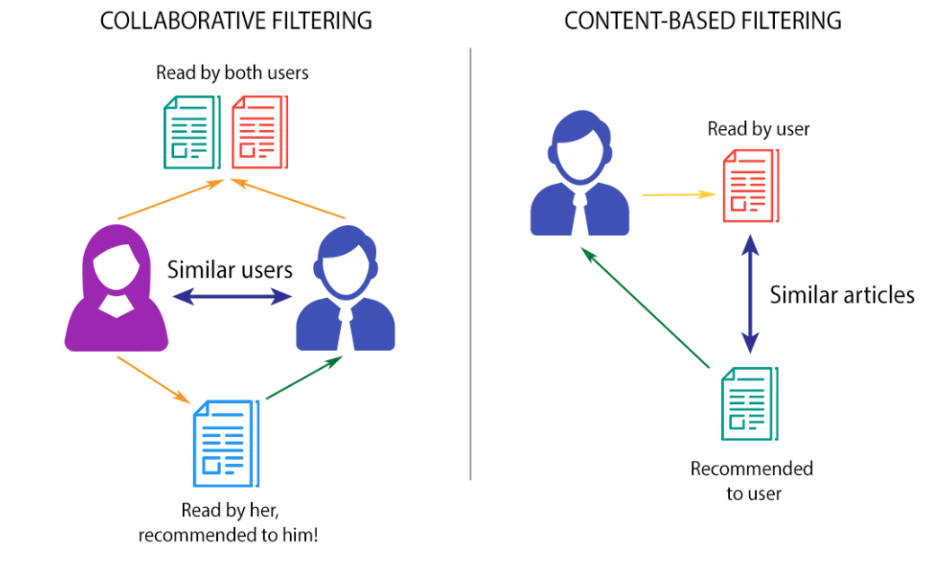
Content-based filtering: A uses some products, recommend other products in the same group for A
Collaborative filtering: A and B use same products in the past -> A and B have sth in common, if A use new thing, recommend that thing to B

At the end, we want to input the name of a restaurant and receive a list of similar restaurants with rating and review. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import re
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
data = pd.read_csv('/kaggle/input/hihihi/zomato.csv', encoding='ISO-8859-1')
data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


Data of restaurants, including:
    online order: whether online order is available in the restaurant or not
    rate: rate of the restaurant
    vote: total rating 
More in: https://www.kaggle.com/code/midouazerty/restaurant-recommendation-system-using-ml/input


1. Data cleaning
* Deleting Unnecessary Columns
* Removing the Duplicates
* Remove the NaN values from the dataset
* Changing the column names
* Data Transformations
* Data Cleaning
* Adjust the column names Now, let’s perform all the above steps in our data:

In [4]:
print(data.isnull().sum())
print(f"Number of duplications is {data.duplicated().sum()}")

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64
Number of duplications is 0


In [5]:
data.drop_duplicates(inplace = True)
data.dropna(inplace = True)
data = data.rename(columns = {
    'approx_cost(for two people)': 'cost',
    'listed_in(type)': 'type',
    'listed_in(city)': 'city'
})
#Ensure we have the right form names
# Remove rows where 'name' contains non-alphabetic characters
# The regex pattern `^[a-zA-Z\s]+$` ensures the name contains only letters and spaces
data = data[data['name'].str.contains(r'^[a-zA-Z\s]+$', na=False)]
data = data.drop(['address', 'url', 'phone', 'rest_type', 'menu_item', 'votes', 'type'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17800 entries, 0 to 51711
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          17800 non-null  object
 1   online_order  17800 non-null  object
 2   book_table    17800 non-null  object
 3   rate          17800 non-null  object
 4   location      17800 non-null  object
 5   dish_liked    17800 non-null  object
 6   cuisines      17800 non-null  object
 7   cost          17800 non-null  object
 8   reviews_list  17800 non-null  object
 9   city          17800 non-null  object
dtypes: object(10)
memory usage: 1.5+ MB


In [6]:
# data['votes'] = data['votes'].astype(float)
#REMOVE /5 from rate column
data = data.loc[data.rate !='NEW']
remove_slash = lambda x: x.replace('/5', '') if type(x) == str else x
data['rate'] = data['rate'].apply(remove_slash).str.strip().astype(float)

#Turn name into right form
data['name'] = data['name'].apply(lambda x : x.title())

data['online_order'].replace(('Yes', 'No'), (1, 0), inplace = True)
data['book_table'].replace(('Yes', 'No'), (1, 0), inplace = True)
data.head()

,name,online_order,book_table,rate,location,dish_liked,cuisines,cost,reviews_list,city
0,Jalsa,1,1,4.1,Banashankari,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Banashankari
1,Spice Elephant,1,0,4.1,Banashankari,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",Banashankari
2,San Churro Cafe,1,0,3.8,Banashankari,"Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",Banashankari
3,Addhuri Udupi Bhojana,0,0,3.7,Banashankari,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",Banashankari
4,Grand Village,0,0,3.8,Basavanagudi,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",Banashankari


In [7]:
data.describe()

,online_order,book_table,rate
count,17688.000000,17688.000000,17688.000000
mean,0.737110,0.223824,3.890038
std,0.440216,0.416817,0.429263
min,0.000000,0.000000,2.000000
25%,0.000000,0.000000,3.700000
50%,1.000000,0.000000,3.900000
75%,1.000000,0.000000,4.100000
max,1.000000,1.000000,4.900000


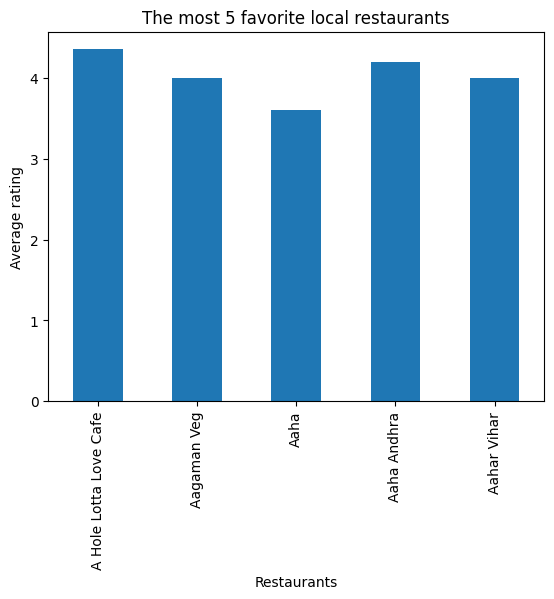

In [8]:
data['name'].unique().size #3157
top5 = data.groupby(['name'])['rate'].mean().head()
top5.plot(kind = 'bar')
plt.xlabel('Restaurants')
plt.ylabel('Average rating')
plt.title('The most 5 favorite local restaurants')
plt.show()

In [9]:
restaurants = list(data['name'].unique())
data['Mean Rating'] = 0

for i in range(len(restaurants)):
    data['Mean Rating'][data['name'] == restaurants[i]] = data['rate'][data['name'] == restaurants[i]].mean()
    
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (1,5))
data[['Mean Rating']] = scaler.fit_transform(data[['Mean Rating']]).round(2)
data[data['name'] == 'Jalsa']

,name,online_order,book_table,rate,location,dish_liked,cuisines,cost,reviews_list,city,Mean Rating
0,Jalsa,1,1,4.1,Banashankari,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Banashankari,3.92
456,Jalsa,1,1,4.1,Banashankari,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Banashankari,3.92
559,Jalsa,1,1,4.1,Banashankari,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Banashankari,3.92
2488,Jalsa,1,1,4.1,Banashankari,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Basavanagudi,3.92
2966,Jalsa,1,1,4.1,Banashankari,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Basavanagudi,3.92
3462,Jalsa,1,1,4.1,Banashankari,"Pasta, Lunch Buffet, Paneer Lajawab, Masala Pa...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n Super ambience\nGreat...",Basavanagudi,3.92
7607,Jalsa,1,1,4.2,Marathahalli,"Mutton Curry, Stuffed Mushroom, Laccha Paratha...","North Indian, Mughlai","1,500","[('Rated 4.0', 'RATED\n A pretty decent place...",Brookefield,3.92
19401,Jalsa,1,1,4.1,Banashankari,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Jayanagar,3.92
20399,Jalsa,1,1,4.1,Banashankari,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Jayanagar,3.92
21302,Jalsa,1,1,4.1,Banashankari,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",Jayanagar,3.92


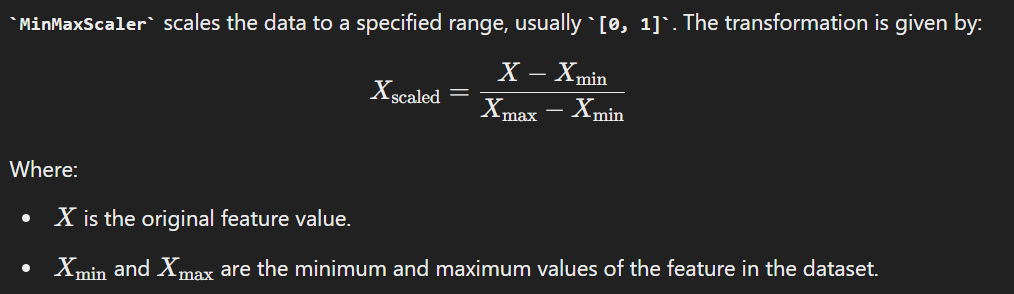

TEXT PROCESSING
* Lower casing
* Removal of Punctuations
* Removal of Stopwords
* Removal of URLs
* Spelling correction

In [10]:
data['reviews_list'] = data['reviews_list'].str.lower()
import string
PUNCT = string.punctuation
def processing_text(text):
    remove = text.maketrans('', '', PUNCT)
    text = text.translate(remove)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Remove any extra spaces or newlines
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove specific unwanted patterns (e.g., 'ratedn', 'n')
    text = re.sub(r'ratedn|n', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Optional: Convert to lowercase
    text = text.lower()
    return text
data['reviews_list'] = data['reviews_list'].apply(lambda x: processing_text(x))
data.head()

,name,online_order,book_table,rate,location,dish_liked,cuisines,cost,reviews_list,city,Mean Rating
0,Jalsa,1,1,4.1,Banashankari,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,rated 40 a beautiful place to die ithe iterior...,Banashankari,3.92
1,Spice Elephant,1,0,4.1,Banashankari,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,rated 40 had bee here for dier with family tur...,Banashankari,3.90
2,San Churro Cafe,1,0,3.8,Banashankari,"Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,rated 30 ambiece is ot that good eough ad its ...,Banashankari,3.48
3,Addhuri Udupi Bhojana,0,0,3.7,Banashankari,Masala Dosa,"South Indian, North Indian",300,rated 40 great food ad proper karataka style f...,Banashankari,3.34
4,Grand Village,0,0,3.8,Basavanagudi,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,rated 40 very good restaurat i eighbourhood bu...,Banashankari,3.48


In [24]:
data.iloc[:,[0, 8]]

,name,reviews_list
0,Jalsa,rated 40 beautiful place die ithe iteriors tak...
1,Spice Elephant,rated 40 bee dier family tured good choose sui...
2,San Churro Cafe,rated 30 ambiece ot good eough ad ot pocket fr...
3,Addhuri Udupi Bhojana,rated 40 great food ad proper karataka style f...
4,Grand Village,rated 40 good restaurat eighbourhood buffet sy...
...,...,...
51700,Bar Bar,rated 40 icreasigly overcrowded mall pub space...
51701,The Beer Cafe,rated 20 wet place little late friday eveig go...
51704,Smaaash,rated 30 like place zomato gold 22 driks wheev...
51705,Izakaya Gastro Pub,rated 30 ice place hagout kids oe part ioa gam...


In [11]:
#Stopword: commonly used words in sentences and often be filtered out to faster training
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
len(STOPWORDS)
def remove_stopword(text):
    new_text = [x for x in text.split() if x not in STOPWORDS]
    return ' '.join(new_text)
data['reviews_list'] = data['reviews_list'].apply(lambda x: remove_stopword(x))

In [12]:
sam_data = data.sample(frac = 0.5)
sam_data.set_index('name', inplace = True)
sam_data.index #return a list of indexes
indices = pd.Series(sam_data.index)

USING TF-IDF to evaluate the importance of words
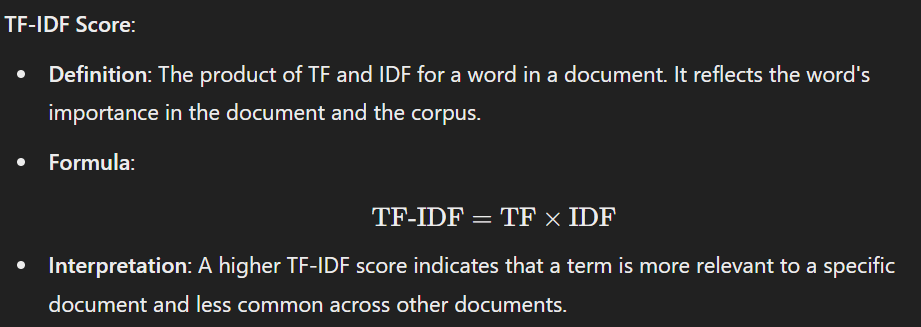

In [14]:
#USING TF-IDF to evaluate the importance of words
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
x= tfidf.fit_transform(sam_data['reviews_list'])
x_array = x.toarray() #num_of_sen x vocal_list
#There are many non-zero values but we can't see

In [21]:
x = pd.Series([1, 2, 0, 5, 4])
x.sort_values(ascending = False)

3    5
4    4
1    2
0    1
2    0
dtype: int64

In [15]:
cosine_similarities = linear_kernel(x_array, x_array) #calculate cosine similarity
cosine_similarities #num_of_sen x num_of_sen
#We have a matrix like this: 
#      Sen A SenB SenC ....
# Sen A  1
# Sen B       1
# Sen C            1
#......
#There higher the values, the more similar among sentences

array([[1.        , 0.05295891, 0.05137563, ..., 0.04255068, 0.13131414,
        0.0385184 ],
       [0.05295891, 1.        , 0.08040234, ..., 0.04017101, 0.08120969,
        0.02784842],
       [0.05137563, 0.08040234, 1.        , ..., 0.03628714, 0.08503212,
        0.04104851],
       ...,
       [0.04255068, 0.04017101, 0.03628714, ..., 1.        , 0.07609715,
        0.03321969],
       [0.13131414, 0.08120969, 0.08503212, ..., 0.07609715, 1.        ,
        0.06705081],
       [0.0385184 , 0.02784842, 0.04104851, ..., 0.03321969, 0.06705081,
        1.        ]])

In [60]:
#When turning a name, we sign to review, then [... ... ... ... ] sen x vocab_size
#this_sen x total_sen
def recommend(name, cosine = cosine_similarities):
    recommend_restaurants = []
    idx = indices[indices == name].index[0]
    #This is the first name we see, actually we see lots of names
    score_series = pd.Series(cosine[idx]).sort_values(ascending = False)
    
    top30_indexes = list(score_series.iloc[0:31].index)
    for idx in top30_indexes:
        if indices[idx] != name and indices[idx] not in recommend_restaurants:
            recommend_restaurants.append(indices[idx])
    data_bonus = pd.DataFrame(columns = ['cuisines', 'Mean Rating', 'cost'])
    for each in recommend_restaurants:
        data_bonus = pd.concat([data_bonus, sam_data[['cuisines', 'Mean Rating', 'cost']][sam_data.index == each].sample()])
    data_bonus = data_bonus.sort_values(by = 'Mean Rating', ascending = False).head(10)
    return data_bonus

In [62]:
#NOW CHECK THE RESULTS
restaurant = input('Type your favorite restaurant here: ')
print(f"There are 10 restaurants for you: {recommend(restaurant)}")

Type your favorite restaurant here:  Jalsa


There are 10 restaurants for you:                                                                          cuisines  \
Asia Kitchen By Mainland China                        Asian, Chinese, Thai, Momos   
The Black Pearl                        North Indian, European, Mediterranean, BBQ   
House Of Commons                                 Continental, Asian, North Indian   
Big Pitcher                     American, Continental, North Indian, Mediterra...   
Communiti                                                 Continental, BBQ, Salad   
Hammered                          North Indian, Thai, Japanese, Continental, Cafe   
Vapour Brewpub And Diner                       North Indian, Continental, Italian   
Jalsa Gold                                         North Indian, Mughlai, Italian   
Brooks And Bonds Brewery        Continental, Mediterranean, North Indian, Chin...   
Delhi Highway                                               North Indian, Mughlai   

                              